In [1]:
import pandas as pd
train_data = pd.read_parquet(r"Data\UNSW_NB15_training-set.parquet", engine="pyarrow")
test_data = pd.read_parquet(r"Data\UNSW_NB15_testing-set.parquet", engine="pyarrow")

print(f"Training data shape: {train_data.shape}")
print(f"Testing data shape: {test_data.shape}")

Training data shape: (175341, 36)
Testing data shape: (82332, 36)


In [2]:
#print the first five rows
train_data.head()

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sload,...,trans_depth,response_body_len,ct_src_dport_ltm,ct_dst_sport_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,is_sm_ips_ports,attack_cat,label
0,0.121478,tcp,-,FIN,6,4,258,172,74.087486,14158.942383,...,0,0,1,1,0,0,0,0,Normal,0
1,0.649902,tcp,-,FIN,14,38,734,42014,78.473373,8395.112305,...,0,0,1,1,0,0,0,0,Normal,0
2,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,1572.271851,...,0,0,1,1,0,0,0,0,Normal,0
3,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,2740.178955,...,0,0,1,1,1,1,0,0,Normal,0
4,0.449454,tcp,-,FIN,10,6,534,268,33.373825,8561.499023,...,0,0,2,1,0,0,0,0,Normal,0


In [3]:
#general information about our dataset
print(f"data described :{train_data.describe()}")
print(f"data information : {train_data.info()}")

data described :                 dur          spkts          dpkts        sbytes  \
count  175341.000000  175341.000000  175341.000000  1.753410e+05   
mean        1.359389      20.298664      18.969591  8.844844e+03   
std         6.480249     136.887597     110.258271  1.747656e+05   
min         0.000000       1.000000       0.000000  2.800000e+01   
25%         0.000008       2.000000       0.000000  1.140000e+02   
50%         0.001582       2.000000       2.000000  4.300000e+02   
75%         0.668069      12.000000      10.000000  1.418000e+03   
max        59.999989    9616.000000   10974.000000  1.296523e+07   

             dbytes            rate         sload         dload  \
count  1.753410e+05   175341.000000  1.753410e+05  1.753410e+05   
mean   1.492892e+04    95406.179688  7.345403e+07  6.712055e+05   
std    1.436542e+05   165400.968750  1.883574e+08  2.421312e+06   
min    0.000000e+00        0.000000  0.000000e+00  0.000000e+00   
25%    0.000000e+00       32.786140 

In [4]:
len(train_data['attack_cat'].unique())

10

In [5]:
print(len(train_data['proto'].unique()))
print(len(train_data['service'].unique()))
print(len(train_data['state'].unique()))
print(len(train_data['label'].unique()))

133
13
9
2


In [6]:
train_data.isnull().sum()

dur                  0
proto                0
service              0
state                0
spkts                0
dpkts                0
sbytes               0
dbytes               0
rate                 0
sload                0
dload                0
sloss                0
dloss                0
sinpkt               0
dinpkt               0
sjit                 0
djit                 0
swin                 0
stcpb                0
dtcpb                0
dwin                 0
tcprtt               0
synack               0
ackdat               0
smean                0
dmean                0
trans_depth          0
response_body_len    0
ct_src_dport_ltm     0
ct_dst_sport_ltm     0
is_ftp_login         0
ct_ftp_cmd           0
ct_flw_http_mthd     0
is_sm_ips_ports      0
attack_cat           0
label                0
dtype: int64

**Explatory data analysis**

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")


We'll start by examining the class distribution of the target variables:

label (binary: normal vs. attack)

attack_cat (categorical: type of attack, optional for more detail)

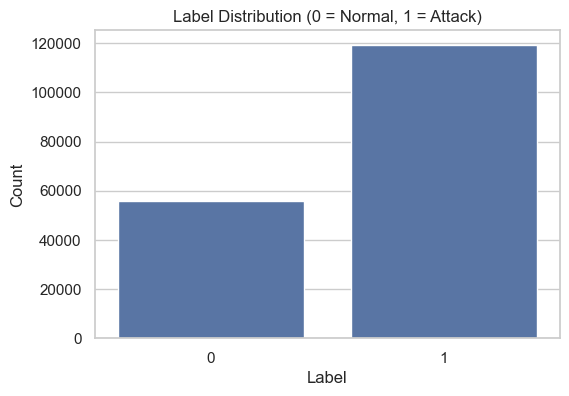

In [8]:
plt.figure(figsize=(6,4))
sns.countplot(x='label', data=train_data)
plt.title('Label Distribution (0 = Normal, 1 = Attack)')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()


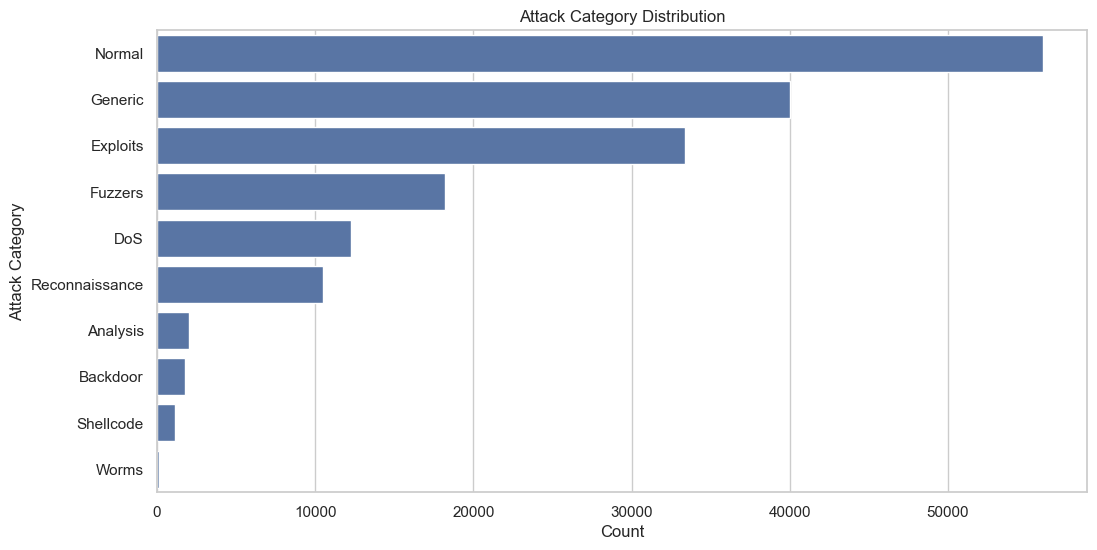

In [10]:
plt.figure(figsize=(12,6))
sns.countplot(y='attack_cat', data=train_data, order=train_data['attack_cat'].value_counts().index)
plt.title('Attack Category Distribution')
plt.xlabel('Count')
plt.ylabel('Attack Category')
plt.show()


In [11]:
print("Label Value Counts:")
print(train_data['label'].value_counts(normalize=True))

if 'attack_cat' in train_data.columns:
    print("\nTop 10 Attack Categories:")
    print(train_data['attack_cat'].value_counts(normalize=True).head(10))


Label Value Counts:
label
1    0.680622
0    0.319378
Name: proportion, dtype: float64

Top 10 Attack Categories:
attack_cat
Normal            0.319378
Generic           0.228127
Exploits          0.190446
Fuzzers           0.103706
DoS               0.069944
Reconnaissance    0.059832
Analysis          0.011406
Backdoor          0.009958
Shellcode         0.006462
Worms             0.000741
Name: proportion, dtype: float64


**Explanation of insights**

Even though our data shows no missing values from the info() output, it’s best to confirm programmatically and check for constant or near-constant features that might be unhelpful for modeling.

In [12]:
missing_values = train_data.isnull().sum()
missing_values = missing_values[missing_values > 0]

if missing_values.empty:
    print("✅ No missing values found.")
else:
    print("⚠️ Missing values:")
    print(missing_values.sort_values(ascending=False))


✅ No missing values found.


In [13]:
nunique = train_data.nunique().sort_values()
print("🔎 Number of unique values per column:")
print(nunique)

constant_features = [col for col in train_data.columns if train_data[col].nunique() <= 1]
if constant_features:
    print(f"\n⚠️ Constant or nearly constant features: {constant_features}")
else:
    print("\n✅ No constant features found.")


🔎 Number of unique values per column:
label                    2
is_sm_ips_ports          2
is_ftp_login             4
ct_ftp_cmd               4
dwin                     7
state                    9
attack_cat              10
trans_depth             11
ct_flw_http_mthd        11
service                 13
swin                    13
ct_dst_sport_ltm        32
ct_src_dport_ltm        47
proto                  133
dloss                  370
sloss                  409
dpkts                  443
spkts                  480
dmean                 1328
smean                 1357
response_body_len     2386
dbytes                6660
sbytes                7214
ackdat               37708
synack               40142
tcprtt               43319
dur                  74039
dinpkt               74177
dtcpb                75089
stcpb                75265
sinpkt               76050
djit                 76743
rate                 76794
sjit                 77390
dload                77474
sload            

Our dataset has categorical columns like proto, service, and state. These describe network behaviors and may hold valuable signals.

✅ What We'll Learn:
Most frequently used protocols (e.g., TCP, UDP, ICMP)

Top services (e.g., HTTP, FTP)

Common connection states (e.g., REJ, CON, FIN)

This helps us:

Understand normal traffic patterns

Spot anomalies or outliers based on rare values

Consider one-hot encoding later for modeling

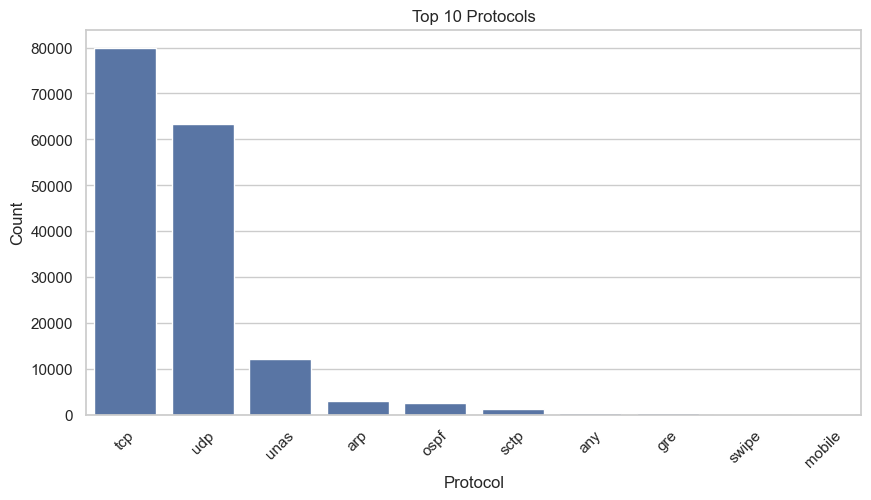

In [14]:
plt.figure(figsize=(10,5))
sns.countplot(x='proto', data=train_data, order=train_data['proto'].value_counts().index[:10])
plt.title('Top 10 Protocols')
plt.xlabel('Protocol')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


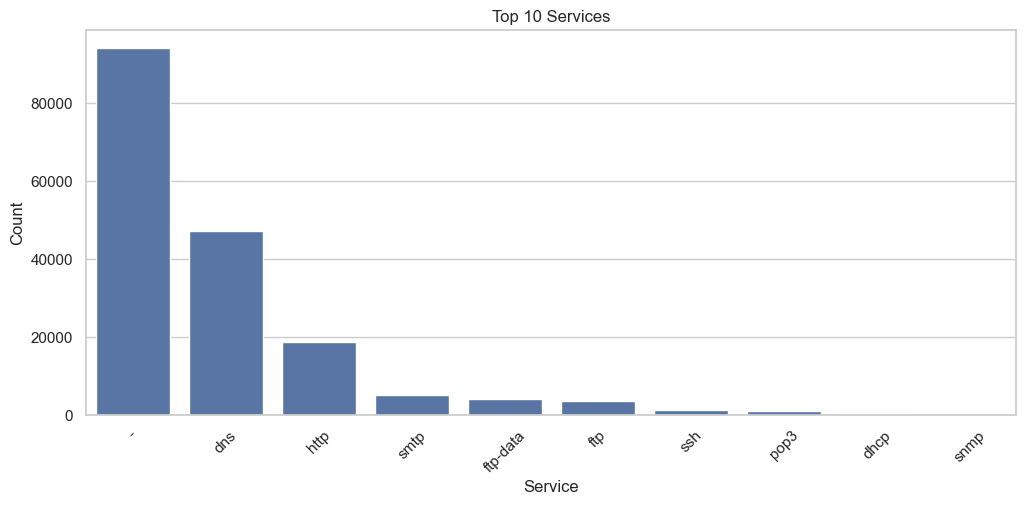

In [16]:
plt.figure(figsize=(12,5))
sns.countplot(x='service', data=train_data, order=train_data['service'].value_counts().index[:10])
plt.title('Top 10 Services')
plt.xlabel('Service')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


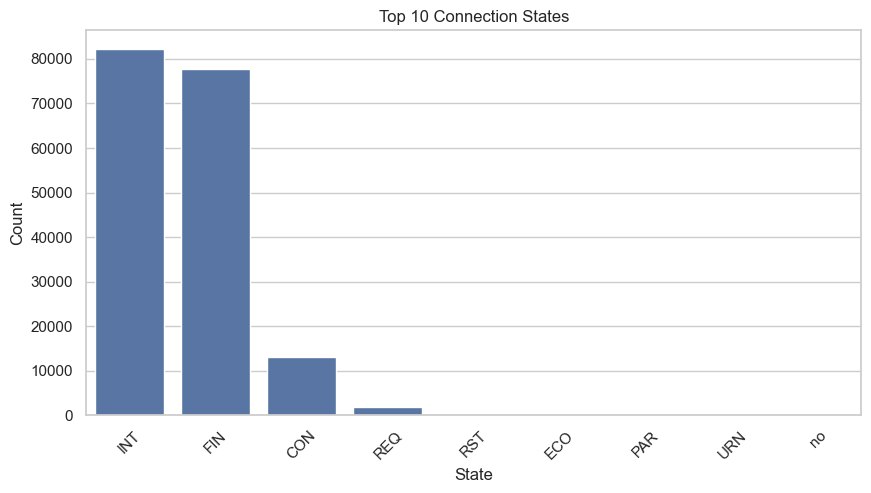

In [17]:
plt.figure(figsize=(10,5))
sns.countplot(x='state', data=train_data, order=train_data['state'].value_counts().index[:10])
plt.title('Top 10 Connection States')
plt.xlabel('State')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


In [18]:
print("Protocol counts:\n", train_data['proto'].value_counts().head(10))
print("\nService counts:\n", train_data['service'].value_counts().head(10))
print("\nState counts:\n", train_data['state'].value_counts().head(10))


Protocol counts:
 proto
tcp       79946
udp       63283
unas      12084
arp        2859
ospf       2595
sctp       1150
any         300
gre         225
swipe       201
mobile      201
Name: count, dtype: int64

Service counts:
 service
-           94168
dns         47294
http        18724
smtp         5058
ftp-data     3995
ftp          3428
ssh          1302
pop3         1105
dhcp           94
snmp           80
Name: count, dtype: int64

State counts:
 state
INT    82275
FIN    77825
CON    13152
REQ     1991
RST       83
ECO       12
PAR        1
URN        1
no         1
Name: count, dtype: int64


Now we focus on the distribution of numerical features like dur, sbytes, dbytes, sload, etc. These help us understand the shape, spread, and presence of outliers, which is critical for anomaly detection.

✅ What we'll Learn:
Are values heavily skewed (e.g., log scale needed)?

Are there extreme outliers that distort model learning?

Do some features need normalization or transformation?



In [19]:
num_cols = train_data.select_dtypes(include=['float32', 'int16', 'int32', 'int64', 'int8']).columns.tolist()
num_cols.remove('label')  # exclude target
print(f"Number of numeric features: {len(num_cols)}")


Number of numeric features: 31


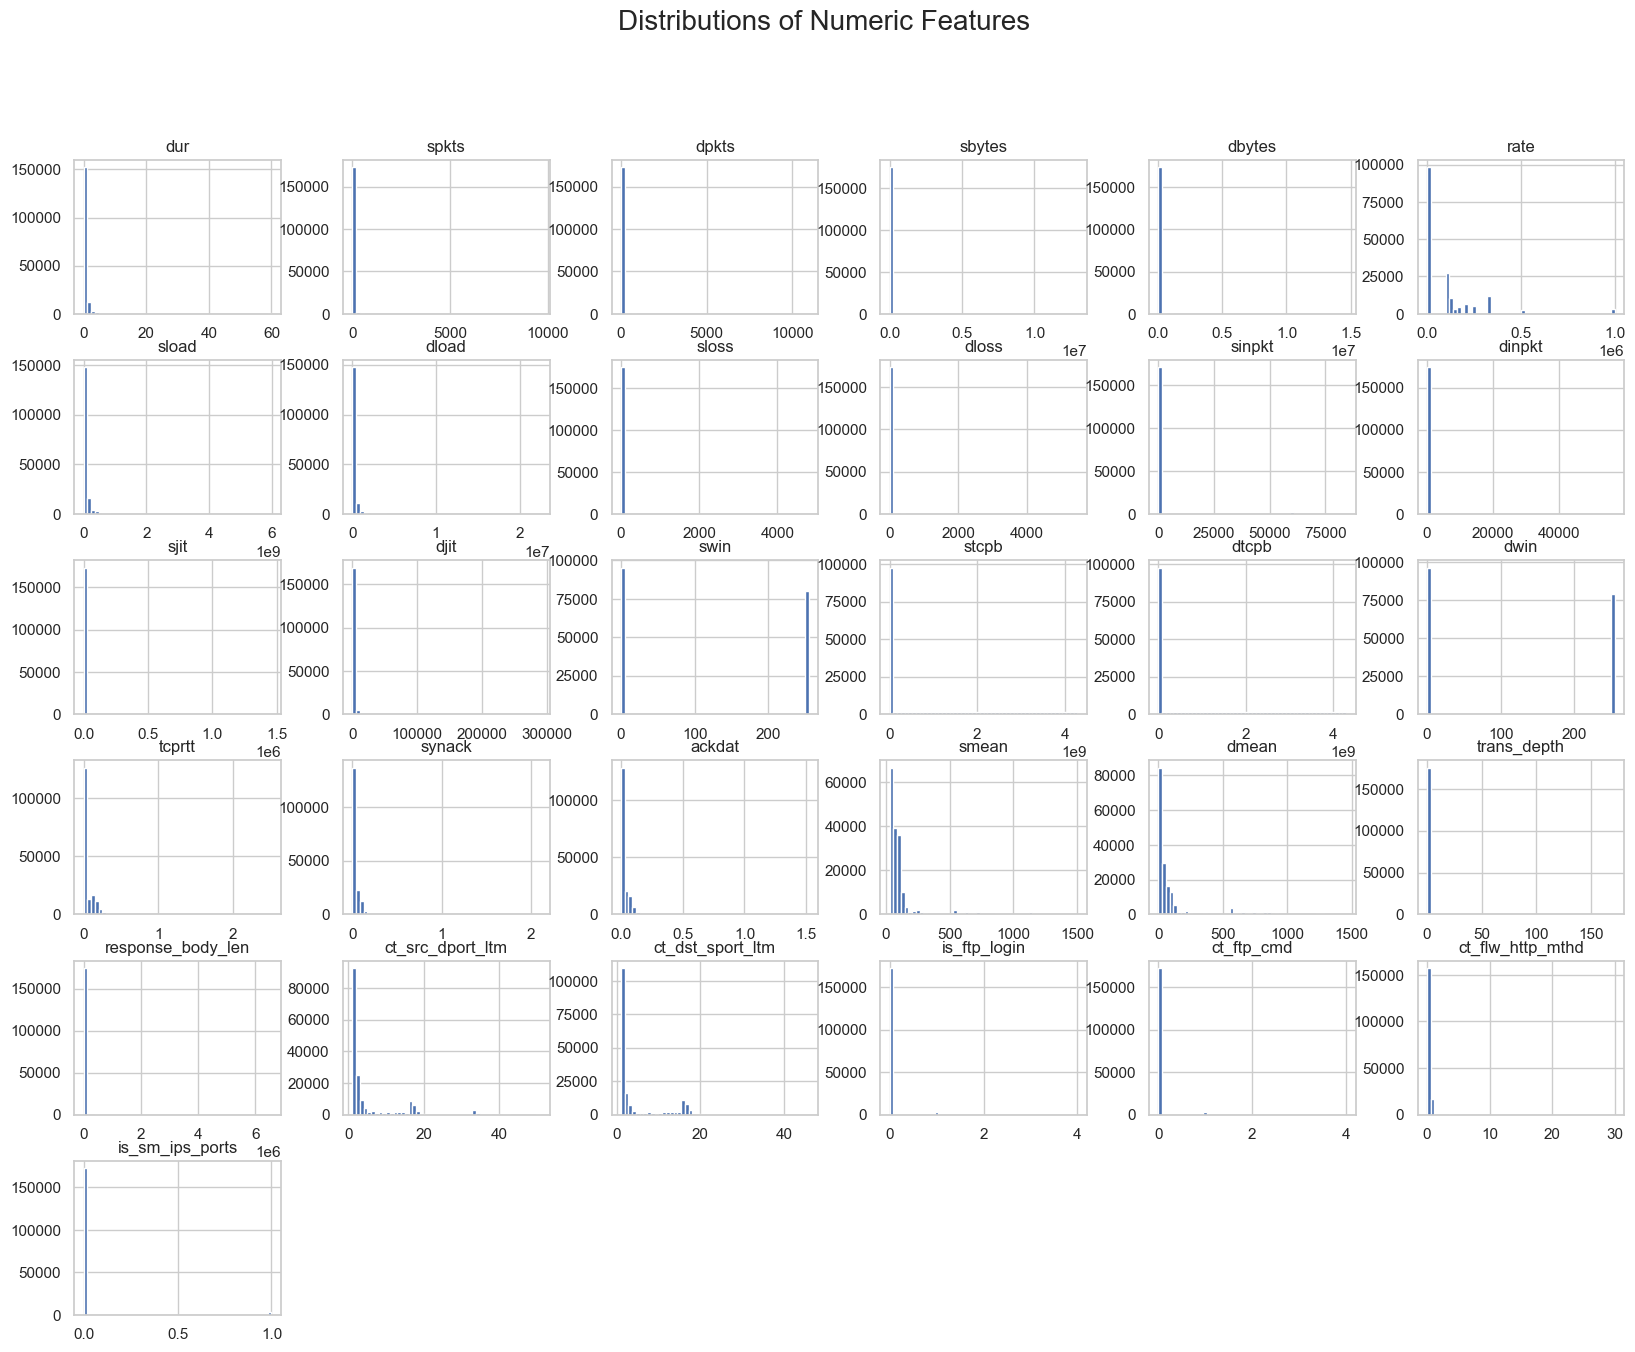

In [20]:
train_data[num_cols].hist(figsize=(20, 15), bins=50)
plt.suptitle('Distributions of Numeric Features', fontsize=20)
plt.show()


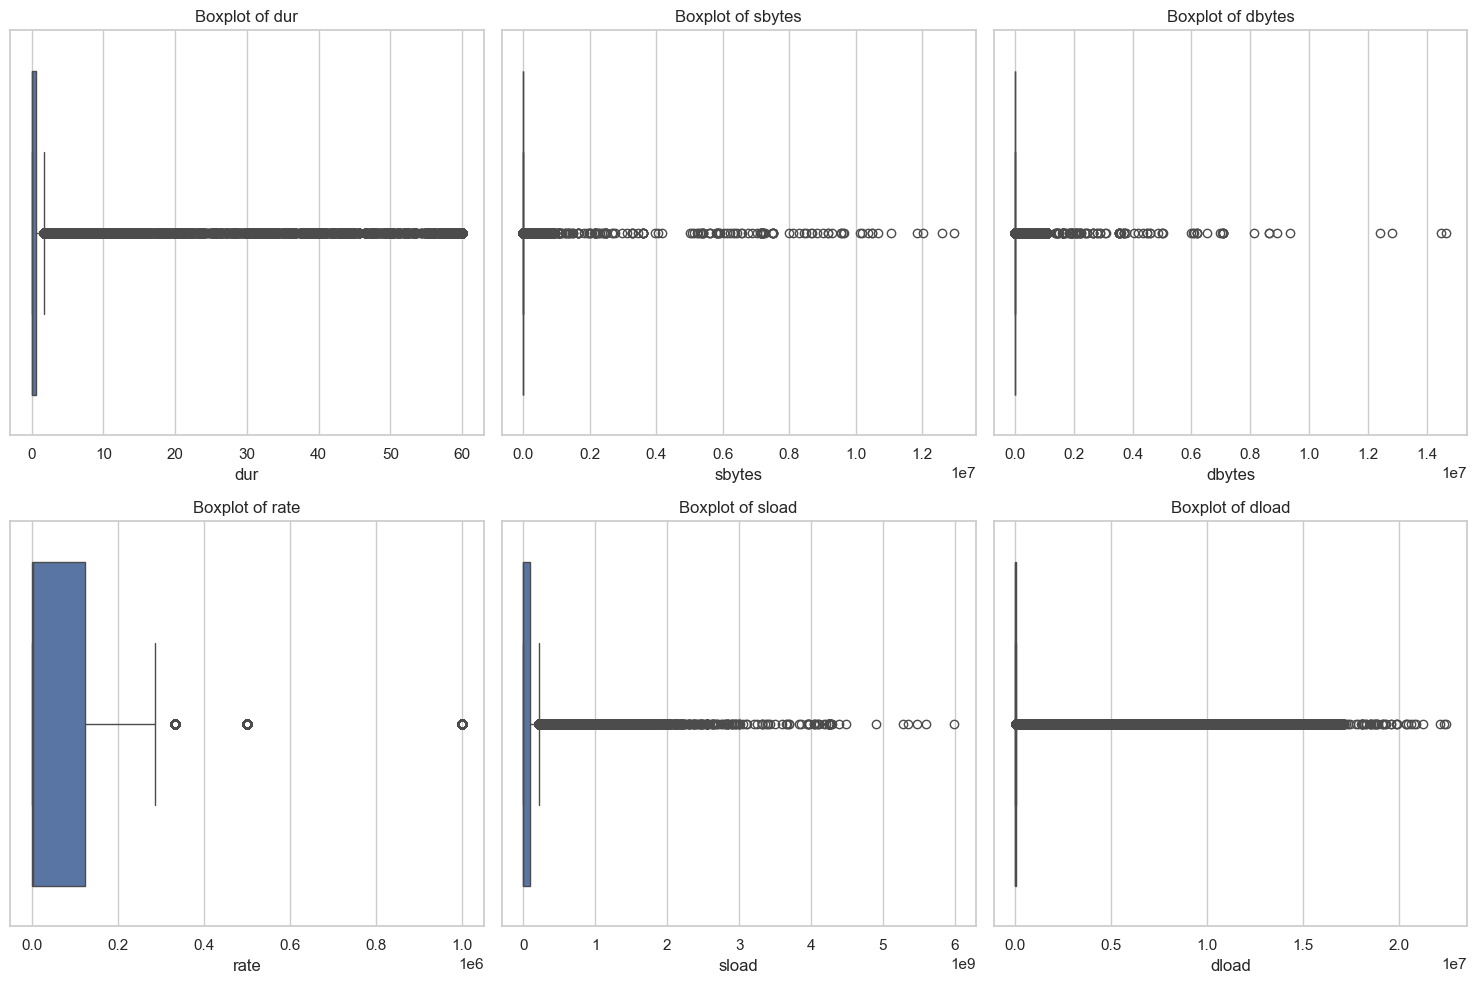

In [21]:
important_cols = ['dur', 'sbytes', 'dbytes', 'rate', 'sload', 'dload']

plt.figure(figsize=(15, 10))
for i, col in enumerate(important_cols):
    plt.subplot(2, 3, i+1)
    sns.boxplot(x=train_data[col])
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()


In [22]:
train_data[num_cols].skew().sort_values(ascending=False).head(10)


trans_depth          167.335829
response_body_len     76.340075
sbytes                45.303443
sloss                 44.753662
dloss                 41.380270
spkts                 40.217703
dbytes                39.760864
dpkts                 36.764114
dinpkt                29.679512
djit                  29.543831
dtype: float64

 Now we move to uncover relationships between features, which is essential for understanding patterns, trends, and potential multicollinearity.

 ✅ What You'll Learn:
 
Are some features strongly correlated? (→ reduce dimensionality)

How do key feature pairs interact across normal vs. attack traffic?

Which features might be predictive when combined?

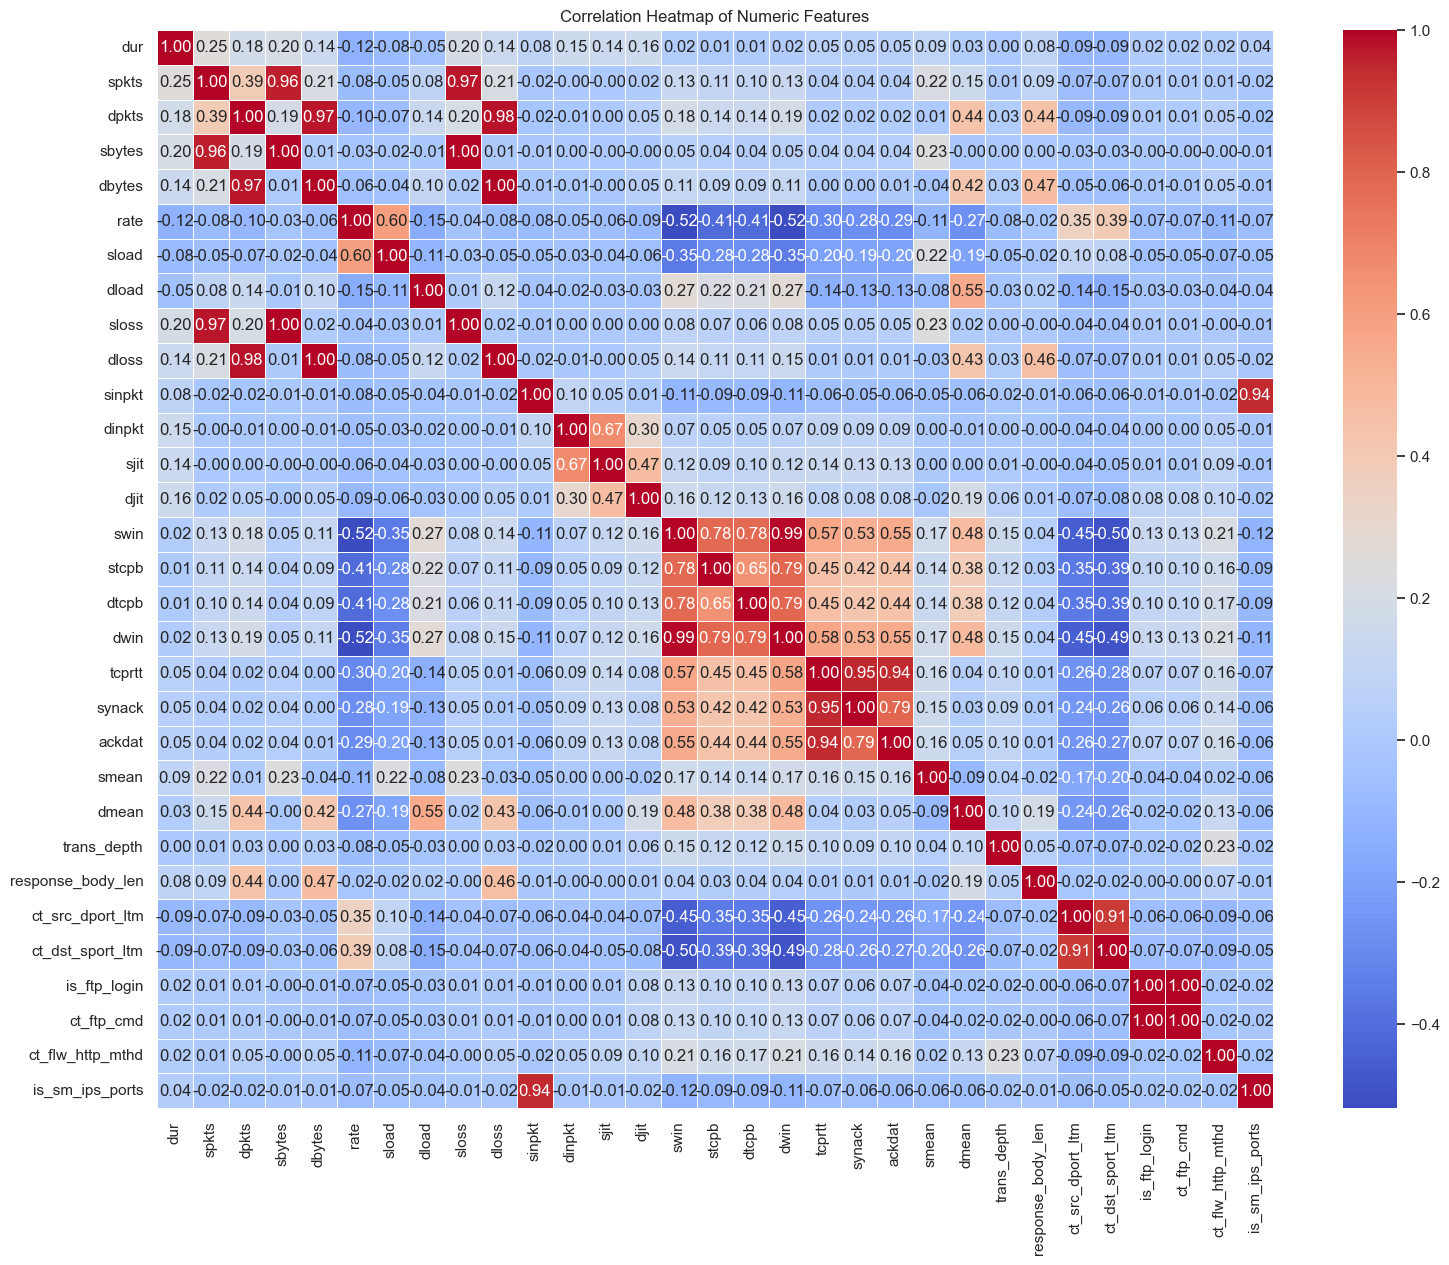

In [24]:
plt.figure(figsize=(18, 14))
corr_matrix = train_data[num_cols].corr()
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap of Numeric Features")
plt.show()


In [25]:
correlations = corr_matrix.abs().unstack().sort_values(ascending=False)
top_corrs = correlations[(correlations < 1) & (correlations > 0.8)]
print("Top highly correlated feature pairs (> 0.8):")
print(top_corrs)


Top highly correlated feature pairs (> 0.8):
dbytes            dloss               0.996504
dloss             dbytes              0.996504
sloss             sbytes              0.996109
sbytes            sloss               0.996109
swin              dwin                0.990140
dwin              swin                0.990140
dpkts             dloss               0.978636
dloss             dpkts               0.978636
dbytes            dpkts               0.971907
dpkts             dbytes              0.971907
spkts             sloss               0.971069
sloss             spkts               0.971069
spkts             sbytes              0.963791
sbytes            spkts               0.963791
synack            tcprtt              0.949468
tcprtt            synack              0.949468
                  ackdat              0.941760
ackdat            tcprtt              0.941760
sinpkt            is_sm_ips_ports     0.941319
is_sm_ips_ports   sinpkt              0.941319
ct_src_dport_lt

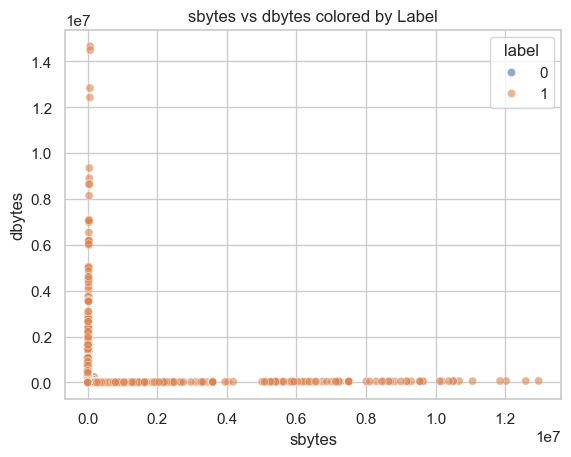

In [26]:
sns.scatterplot(data=train_data, x='sbytes', y='dbytes', hue='label', alpha=0.6)
plt.title('sbytes vs dbytes colored by Label')
plt.show()


In [ ]:
sns.scatterplot(data=train_data, x='dur', y='sload', hue='label', alpha=0.6)
plt.title('dur vs sload colored by Label')
plt.show()
